In [2]:
import pandas as pd
import scipy as sc
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from operator import truediv, mul

# Data_cleaned

In [3]:
data_cleaned = pd.read_csv("data/data_cleaned.csv")
label = data_cleaned["Categorie1"].values
label_1=[]
label_2=[]
label_3=[]
for k in label:
    if k=="TELEPHONIE - GPS":
        label_1+=[1]
        label_2+=[0]
        label_3+=[0]
    elif k=="INFORMATIQUE":
        label_1+=[0]
        label_2+=[1]
        label_3+=[0]
    elif k=="LIBRAIRIE":
        label_1+=[0]
        label_2+=[0]
        label_3+=[1]
    else:
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        
features = sc.sparse.load_npz("data/feature_sparse.npz")

## Comments:

On crée différents labels pour observer différents types de régression. Les labels 1,2,3 permettent ainsi de faire des regression binaires resp. sur les catégories TELEPHONIE - GPS , INFORMATIQUE, LIBRAIRIE. 

Question: faire des regressions binaire en jouant sur le paramètre "multi_class" de LR

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1, random_state=42)

In [4]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features, label_1, test_size=0.1, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, label_2, test_size=0.1, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features, label_3, test_size=0.1, random_state=42)

### Apprentissage par classe:

In [5]:
lr_1= LogisticRegression()
lr_1.fit(X_train_1,y_train_1)
train_score_1 = lr_1.score(X_train_1,y_train_1)
print(train_score_1)

0.9934111111111111


/Users/paulbrunet/anaconda3/envs/Projet4A/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [6]:
lr_2= LogisticRegression()
lr_2.fit(X_train_2,y_train_2)
train_score_2 = lr_2.score(X_train_2,y_train_2)
print(train_score_2)

0.9930333333333333


/Users/paulbrunet/anaconda3/envs/Projet4A/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [7]:
lr_3= LogisticRegression()
lr_3.fit(X_train_3,y_train_3)
train_score_3 = lr_3.score(X_train_3,y_train_3)
print(train_score_3)

0.9973222222222222


### Apprentissage mutliclasse

In [8]:
ts = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")
train_score = lr.score(X_train,y_train) 
print(train_score) #Nombre de descriptions dont la prédiction est juste/Nombre de descriptions total

/Users/paulbrunet/anaconda3/envs/Projet4A/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


56.74605584144592 sec
0.9869777777777777


### Prediction

In [6]:
predict_1 = lr_1.predict(X_train_1)

In [11]:
predict_2 = lr_2.predict(X_train_2)

In [12]:
predict_3 = lr_3.predict(X_train_3)

In [13]:
predict = lr.predict(X_train)

In [14]:
test_score = lr.score(X_test,y_test)
print("Score multi :",test_score, "\n")

print("Scores pour les regressions log binaires : \n")
test_score_1 = lr_1.score(X_test_1,y_test_1)
print("  Score GPS :",test_score_1, "\n")
test_score_2 = lr_2.score(X_test_2,y_test_2)
print("  Score INFO :",test_score_2, "\n")
test_score_3 = lr_3.score(X_test_3,y_test_3)
print("  Score LIB :",test_score_3, "\n")

Score multi : 0.9011 

Scores pour les regressions log binaires : 

  Score GPS : 0.9876 

  Score INFO : 0.9862 

  Score LIB : 0.9867 



In [7]:
def cross_cat(predictee,trainee):
    A= pd.crosstab(trainee, predictee, rownames=["Ground True"], colnames=["Prediction"])
    cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    PTP=[1][1]
    PFN=[1][0]
    PFP=[0][1]
    PTN=[0][0]
    return len(y_train),PTP,PFN,PFP,PTN

In [8]:
print(len(y_train_1))
print(len(predict_1))

A=pd.crosstab(y_train_1,predict_1)

90000
90000


KeyboardInterrupt: 

In [ ]:
print()
nb_data_1,PTP_1,PFN_1,PFP_1,PTN_1=cross_cat(predict_1,y_train_1)

### Plot

In [78]:
cat = list(set(y_train)) #recup toutes les categories

TP=[] #effectif
FN=[]
nb_data=[]

for i in cat :
    cat_name = str(i)
    Y_train_predict_cat = Y_train_predict==cat_name
    y_train_cat = y_train==cat_name
    n_data = 0
    for k in y_train_cat:
        if k== True:
            n_data +=1
    nb_data += [n_data]
    A=pd.crosstab(y_train_cat, Y_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    TP += [A[1][1]]
    FN += [A[0][1]]

/Users/paulbrunet/anaconda3/envs/Projet4A/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


KeyError: 1

In [12]:
d = {'data':nb_data, 'True positive':TP, 'False negative':FN}
pd.DataFrame(d).T

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
data,0,1919,2302,331,10,235,5414,180,4282,59,...,1732,2850,1223,152,1826,19173,144,289,135,4
True positive,0,1904,2240,322,10,228,5405,177,4232,59,...,1722,2789,1177,148,1772,19079,139,281,135,3
False negative,0,15,62,9,0,7,9,3,50,0,...,10,61,46,4,54,94,5,8,0,1


In [1]:
fig=plt.figure(figsize=(20,10))
plt.title("Nombre de vrai positif (bien classé) en fonction du nb de données d'apprentissage")
plt.plot(nb_data, TP, 'bo', label="True positive")
plt.xlabel('Data')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

Afficher en % pour voir clairement
predit positif /positif

Isoler les plots des calculs et mettre les set d'apprentissage en paramètre

Faire varier l'apprentissage par catégorie

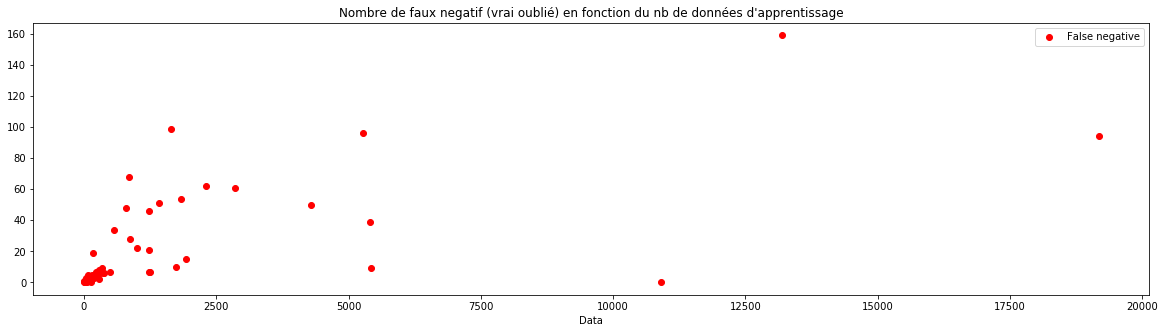

In [10]:
fig=plt.figure(figsize=(20,5))
plt.title("Nombre de faux negatif (vrai oublié) en fonction du nb de données d'apprentissage")
plt.plot(nb_data,FN, "ro", label="False negative")
plt.xlabel('Data')
plt.legend()
plt.show()

### Comments:

Pas ouf, ca sert à rien de voir sur l'ensemble des catégories on veut voir l'évolution par catégorie

In [5]:
def comput_plot_category(cat,datamin=10000,datamax=90000,measures=10):
    TP = []
    FN = []
    nb_data=[]
    PFN =[]
    PFP =[]

    cat_name=str(cat)
    
    scale =int((datamax-datamin)/measures)
    for nb_used in range(datamin,datamax,scale): ## Regression en faisant varier notre nb données utilisé pr l'apprentissage
        X_small_train = X_train[0:nb_used]
        y_small_train = y_train[0:nb_used]
        lr_small = LogisticRegression(n_jobs=-1)
        lr_small.fit(X_small_train, y_small_train)
        Y_small_train_predict = lr_small.predict(X_small_train)
        Y_small_train_predict_cat = Y_small_train_predict==cat_name
        y_small_train_cat = y_small_train==cat_name
        n_data = 0
        for k in y_small_train_cat:
            if k == True:
                n_data +=1
        nb_data += [n_data]
        A=pd.crosstab(y_small_train_cat, Y_small_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])
        AB = A.divide(A.sum(axis=1),axis=0)*100
        TP += [A[1][1]]
        PTP += [AB[1][1]]
        FN += [A[0][1]]
        PFN += [AB[0][1]]
        PFP += [AB[1][0]]
    return nb_data,PFP,PFN,PTP  

In [68]:
def plot_category(nb_data,PFP, PFN,PTP,PTN):
    fig=plt.figure(figsize=(8,5))
    plt.title("Evolution des faux positifs en fonction du nb de données d'apprentissage pour la catégorie")
    plt.plot(nb_data,PFP, "ro", label="Faux positifs")
    plt.xlabel("Data used for the training part")
    plt.legend()
    plt.show()

    fig=plt.figure(figsize=(8,5))
    plt.title("Evolution des false negative en % en fonction du nb de données d'apprentissage pour la catégorie")
    plt.plot(nb_data,PFN, "go",label="False Negative %")
    plt.xlabel("Data used for the training part")
    plt.legend()
    plt.show()

    fig=plt.figure(figsize=(8,5))
    plt.title("Evolution des vrai positifs en fonction du nb de données d'apprentissage pour la catégorie")
    plt.plot(nb_data,PTP, "bo",label="True Positive")
    plt.xlabel("Data used for the training part")
    plt.legend()
    plt.show()
    
    fig=plt.figure(figsize=(8,5))
    plt.title("Evolution des vrai positifs en fonction du nb de données d'apprentissage pour la catégorie")
    plt.plot(nb_data,PTN, "bo",label="True Positive")
    plt.xlabel("Data used for the training part")
    plt.legend()
    plt.show()

### Comments:

Ce qu'on veut: tracer l'évoluion du True true d'une catégorie en fonction de la quantité de données d'apprentissage

Asbtract : pas assez de données labelisés, compliquée, word embedding -> generer des features permmeette solution on va le montrer

classification sur des données labélisés en utilisant des connaissancees sur des données non labélisés. 

casser le probleme de manque de données labélisés

nouvel espace interpreter ces features

## Reduction X train

In [11]:
nb = 50000
X_small_train = X_train[0:nb]
y_small_train = y_train[0:nb]

In [12]:
lr_small = LogisticRegression()
lr_small.fit(X_small_train, y_small_train)
lr.score(X_small_train,y_small_train)

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.98684

In [13]:
Y_small_train_predict = lr_small.predict(X_small_train)
lr_small.score(X_test,y_test)

0.8833

In [14]:
print(train_score)
print(test_score) 

0.9869777777777777
0.9011


### Comments :

- Ok donc la prediction est moins bonne ce qui est logique car il y a moins de données d'apprentissage au préalable
- Peut etre essayer que sur les 3 plus grandes catégories voir ce que ça donne ?

# Bad_data_cleaned (cf fichier Vectorization)

In [15]:
bad_data_cleaned = pd.read_csv("data/bad_data_cleaned.csv") 
label = bad_data_cleaned["Categorie1"].values
bad_features = sc.sparse.load_npz("data/bad_feature_sparse.npz")
X_train, X_test, y_train, y_test = train_test_split(bad_features, label, test_size=0.1, random_state=42)
lr_bad = LogisticRegression()

In [16]:
ts = time.time()
lr_bad.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")

51.46840214729309 sec


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
Y_train_predict = lr_bad.predict(X_train)
lr_bad.score(X_train,y_train)

0.9879555555555556

In [18]:
lr_bad.score(X_test,y_test)

0.9012

### Comments :

- Ok donc on est un peu meilleur en prédiction avec "un bad_cleaning" : sans enlever les stopwords dans les tokens
- La raison ?
- Par contre on met plus de temps lors de l'apprentissage mais logique